# Workshop CentraleSupélec - CeSIA - Partie 2

- Création : 02/2025 par [Nicolas Guillard](mailto:nicolas.guillar@securite-ia.fr) - bénévole au [CeSIA](https://www.securite-ia.fr/).

Créer en adaptant et complétant le projet [Générer des noms de villes et communes françaises](https://github.com/alxndrTL/villes) par [Alexandre TL](https://www.youtube.com/@alexandretl)

## Présentation du sujet et Plan

## Indications

Les éléments de ce TP :
- le présent carnet,
  
(et ceux qui seront installés grâce au script `Installation de l'environnement de travail`),
- le répertoire `./utils` et les fichiers contenus,
- le répertoire `./weights` contenant les poids des modèles utiles et ceux produits,
- le répertoire `./images` contenant les illustrations des carnets,
- le fichier de données `./villes.txt`.

## Installation de l'environnement de travail

Le script ci-dessous est destiné à installer les éléments nécessaires au fonctionnement de ce carnet.

In [1]:
import sys
from pathlib import Path

IN_COLAB = "google.colab" in sys.modules

repo = "workshop_cs_202503"
branch = "main"
url_repo = f"https://github.com/nicolasguillard/{repo}/archive/refs/heads/{branch}.zip"
target_dir = (
  "/content"
  if IN_COLAB
  else "."
)
resources = ["utils", "weights", "images", "villes.txt"]

if not Path(f"{target_dir}/utils").exists() :
  print("=== Installation des ressources utiles à ce carnet ===")
  !wget -P {target_dir} {url_repo}
  !unzip {target_dir}/{branch}.zip -d {target_dir}
  for resource in resources:
    !mv {target_dir}/{repo}-{branch}/{resource} {target_dir}/{resource}
  !rm -rf {target_dir}/{repo}-{branch}
  !rm -f {target_dir}/{branch}.zip
  print("=== Terminé ===")

  if IN_COLAB:
    print("--- Rafraichissez au besoin la liste des fichiers à gauche si nécessaire ---")
else:
  print("Il semble que des ressources nécessaires pour ce carnet soient déjà installés :")
  for resource in resources:
    print("\t", f"./{resource}", "présent" if Path(f"{target_dir}/{resource}").exists else "absent")
  print("Pour supprimer les ressources automatiquement installées, utilisez la fonction 'remove_resources()' dans un autre bloc de code.")

def remove_resources():
  !rm -rf {target_dir}/{repo}-{branch}
  for resource in resources:
    !rm -rf {target_dir}/{resource}

Il semble que des ressources nécessaires pour ce carnet soient déjà installés :
	 ./utils présent
	 ./weights présent
	 ./images présent
	 ./villes.txt présent
Pour supprimer les ressources automatiquement installées, utilisez la fonction 'remove_resources()' dans un autre bloc de code.


## Les modules et paramétrages globaux

Tous les modules nécessaires sont importés. A moins d'un besoin spécifique, il n'y aura pas besoin de modifier le bloc de code suivant.

In [2]:
# Modules prédéfinis et tiers
import math
import datetime
from dataclasses import dataclass

import seaborn as sns
import pandas as pd
from tqdm.notebook import trange, tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

In [3]:
#Modules créés pour le projet
from utils import get_datasets, SOS, EOS, PAD
from utils import LanguageModel, CharTokenizer

### Device

Sélection du GPU selon l'environnement de travail

In [4]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


### Paramétrages

In [5]:
# Retirer la limite du nombre maximal de lignes affichées dans un tableau pandas
pd.set_option('display.max_rows', None) 

In [6]:
# Configurer le thème de seaborn
sns.set_theme(style="whitegrid")

In [7]:
# Paramétrer les graines aléatoires
#pth_rnd_gen_device = torch.Generator(device).manual_seed(42)
if device == "cuda":
    pth_rnd_gen_device = torch.cuda.manual_seed(42)
elif device == "mps":
    pth_rnd_gen_device = torch.mps.manual_seed(42)
pth_rnd_gen_cpu = torch.manual_seed(42)
pth_rnd_gen = pth_rnd_gen_cpu if device == "cpu" else pth_rnd_gen_device

## Le modèle de langue

Le modèle est un Transformer inspiré de LLAMA 2. Il est composé d'un ensemble de modules dont le code des classes est fourni ci-dessous.

![](https://drive.google.com/uc?id=1Kag6BuRKdInm7TYHl0qIZiSmnKHz3mKS)

![Modèle de langue](./images/language_model_details.png)

### Modules prédéfinis

In [8]:
@dataclass
class TransformerConfig:
    """
    """
    vocab_size: int
    d_model: int # D or d_model in comments
    n_layers: int
    n_heads: int
    max_len: int # maximum sequence length (for positional embedding)
    dropout: float = 0.1
    bias: bool = False
    norm_eps: float = 1e-5
    super_attn: bool = False # overwrites flash to False
    flash: bool = True

    def __post_init__(self):
        assert self.d_model % self.n_heads == 0, "d_model must be a multiple of n_heads"

        self.d_head = self.d_model // self.n_heads

In [9]:
class RMSNorm(torch.nn.Module):
    """
    Root Mean Square Layer Normalization
    """
    def __init__(self, dim: int, eps: float) -> None:
        """
        Args :
            dim (int) : 
            eps (float) :
        """
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))

    def _norm(self, x: torch.Tensor) -> torch.Tensor:
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        output = self._norm(x.float()).type_as(x)
        return output * self.weight

In [10]:
class SelfAttentionMultiHead(nn.Module):
    def __init__(self, config: TransformerConfig) -> None:
        """
        Args :
            config (TransformerConfig) :
        """
        super().__init__()

        self.config = config

        # key, query, value projections for all heads
        self.query_proj = nn.Linear(config.d_model, config.d_model, bias=False) # d_query = n_heads*d_head as in the Transformer paper
        self.key_proj = nn.Linear(config.d_model, config.d_model, bias=False)
        self.value_proj = nn.Linear(config.d_model, config.d_model, bias=False)

        if not config.flash:
            # compute the mask once and for all here 
            # registrer treats it like a parameter (device, state_dict...) without training
            mask = torch.full((1, 1, config.max_len, config.max_len), float('-inf'))
            mask = torch.triu(mask, diagonal=1)
            self.register_buffer('mask', mask)

        # LxL super attention params
        if config.super_attn:
            self.k_in_v_proj = nn.Linear(in_features=config.max_len, out_features=config.max_len, bias=False)

        # output projection
        self.c_proj = nn.Linear(config.d_model, config.d_model, bias=config.bias)

        # regularization
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args :
            x (torch.Tensor) : input shaped (B, S, d_model)
        """
        B, S, _ = x.size()

        Q = self.query_proj(x).view(B, S, self.config.n_heads, self.config.d_head).transpose(1, 2) # (B, n_heads, S, d_query)
        K = self.key_proj(x).view(B, S, self.config.n_heads, self.config.d_head).transpose(1, 2) # (B, n_heads, S, d_key)
        V = self.value_proj(x).view(B, S, self.config.n_heads, self.config.d_head).transpose(1, 2) # (B, n_heads, S, d_head=d_value)

        if self.config.flash and not self.config.super_attn:
            attention = F.scaled_dot_product_attention(
                Q, K, V, attn_mask=None, dropout_p=self.config.dropout if self.training else 0, is_causal=True
                )
        else:
            QK_T = Q @ torch.transpose(K, 2, 3) # (B, n_heads, S, S)
            QK_T = QK_T + self.mask[:, :, :S, :S]

            attention_scores = torch.softmax(QK_T / math.sqrt(self.config.d_head), dim=3) # (B, n_heads, S, S)

            if self.config.super_attn:
                attention = self.attn_dropout(attention_scores) @ self.k_in_v_proj.weight @ V # (B, n_h, L, d_value=d_head)
            else:
                attention = self.attn_dropout(attention_scores) @ V # (B, n_h, S, d_value=d_head)

        attention = attention.transpose(1, 2) # (B, S, n_heafs, d_head)
        y = attention.contiguous().view(B, S, self.config.d_model) # n_heads * d_head = d_model

        y = self.resid_dropout(self.c_proj(y))

        return y # (B, S, d_model)

In [11]:
class MLP(nn.Module):
    def __init__(self, config: TransformerConfig) -> None:
        """
        Args :
            config (TransformerConfig) : configuration settings
        """
        super().__init__()

        self.fc_1 = nn.Linear(config.d_model, 4 * config.d_model, bias=config.bias)
        self.fc_2 = nn.Linear(4 * config.d_model, config.d_model, bias=config.bias)
        self.fc_3 = nn.Linear(config.d_model, 4 * config.d_model, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args :
            x (torch.Tensor) : input data  shaped (B, S, d_model)
        """
        x = self.dropout(self.fc_2(F.silu(self.fc_1(x)) * self.fc_3(x)))
        return x # (B, S, d_model)

In [12]:
class DecoderLayer(nn.Module):
    def __init__(self, config: TransformerConfig) -> None:
        """
        Args :
            config (TransformerConfig) :
        """
        super().__init__()

        self.config = config

        self.attention_norm = RMSNorm(config.d_model, config.norm_eps)
        self.sa = SelfAttentionMultiHead(config)
        self.mlp_norm = RMSNorm(config.d_model, config.norm_eps)
        self.mlp = MLP(config)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
         Args :
            x (torch.Tensor) : input data shaped (B, S, d_model)
        """
        x = x + self.sa(self.attention_norm(x))
        x = x + self.mlp(self.mlp_norm(x))

        return x # (B, S, d_model)

In [13]:
class Transformer(nn.Module):
    def __init__(self, config: TransformerConfig) -> None:
        """
        """
        super().__init__()

        self.config = config

        # Positional Embedding
        self.PE = nn.Embedding(config.max_len, config.d_model)
        self.in_dropout = nn.Dropout(config.dropout)
        self.layers = nn.ModuleList([DecoderLayer(config) for _ in range(config.n_layers)])

    def forward(self, x: torch.Tensor, stop_at_layer: int = -1) -> torch.Tensor:
        """
        Args :
            x (torch.Tensor) : input data shaped (B, S, d_model)
            stop_at_layer (int) : return the ouput (activations) after the specified {layer}-th layer (1 -> n_layers)
        """
        if stop_at_layer < 0:
            stop_at_layer += len(self.layers) + 1
        elif stop_at_layer == 0:
            stop_at_layer = 1
        assert stop_at_layer <= len(self.layers), \
            f"stop_at_layer ({stop_at_layer}) should be in [{-len(self.layers)}, {len(self.layers)}]"
        _, S, _ = x.size()

        # Add positional embedding
        pos_emb = self.PE(torch.arange(0, S, dtype=torch.long, device=x.device))
        x = self.in_dropout(x + pos_emb)

        for i, layer in enumerate(self.layers):
            x = layer(x) # (B, S, d_model)

            if stop_at_layer == i+1:
                return x
        
        return x # (B, S, d_model)

### EXERCICE(S) : Définition de la classe du modèle de langue

Il s'agit de compléter le code de la classe du modèle `LanguageModel` ci-dessous, c'est-à-dire les méthodes `__init__()` et `forward()` en interprétant le schéma du modèle de langue fourni plus haut.

> Conseil(s) :
> - utilisation de la méthode `get_logits_()` dans `forward()`.
> - `self.core` fait référence à la partie "Transformer" du modèle.
> - `self.lm_head` correspond à "Unembedding".

<details> 
<summary>Eléments d'énoncé</summary>

```python
class LanguageModel(nn.Module):
    def __init__(self, model_config: TransformerConfig) -> None:
        super().__init__()

        self.config = model_config
        self.embedding = None ### EXERCICE : remplacer None par les bonnes instructions 
        
        self.core = None ### EXERCICE : remplacer None par les bonnes instructions 
        self.out_norm = None ### EXERCICE : remplacer None par les bonnes instructions
        self.lm_head = None ### EXERCICE : remplacer None par les bonnes instructions
        self.lm_head.weight = self.embedding.weight

        self.apply(self._init_weights)
        self._init_normal()

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def _init_normal(self, module):
        for pn, p in self.named_parameters():
            if pn.endswith('fc_3.weight') or pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * self.config.n_layers))
    
    def get_logits_(self, x: torch.Tensor) -> torch.Tensor:
        x = self.out_norm(x)
        return self.lm_head(x)

    def forward(self, tokens: torch.Tensor) -> torch.Tensor:
        """
        Args :
            tokens (torch.Tensor) : input shaped (B, s, vocab_size) with s in [1; S]
        """

        ### EXERCICE : compléter ce bloc avec les bonnes instructions 
        # DEBUT DE BLOC

        ### EXERCICE : à compléter

        logits = None ### EXERCICE : remplacer None par les bonnes instructions 
        # FIN DE BLOC
        return logits #(B, S, vocab_size)  
```
</details>

> Solution(s) :

In [14]:
class LanguageModel(nn.Module):
    def __init__(self, model_config: TransformerConfig) -> None:
        super().__init__()

        self.config = model_config
        self.embedding = nn.Embedding(self.config.vocab_size, self.config.d_model, padding_idx=0) ### EXERCICE : remplacer None par les bonnes instructions
        
        self.core = Transformer(self.config) ### EXERCICE : remplacer None par les bonnes instructions
        self.out_norm = RMSNorm(self.config.d_model, self.config.norm_eps) ### EXERCICE : remplacer None par les bonnes instructions
        self.lm_head = nn.Linear(self.config.d_model, self.config.vocab_size, bias=False) ### EXERCICE : remplacer None par les bonnes instructions
        self.lm_head.weight = self.embedding.weight

        self.apply(self._init_weights)
        self._init_normal()

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def _init_normal(self):
        for pn, p in self.named_parameters():
            if pn.endswith('fc_3.weight') or pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * self.config.n_layers))
    
    def get_logits_(self, x: torch.Tensor) -> torch.Tensor:
        x = self.out_norm(x)
        return self.lm_head(x)

    def forward(self, tokens: torch.Tensor) -> torch.Tensor:
        """
        Args :
            tokens (torch.Tensor) : input shaped (B, s, vocab_size) with s in [1; S]
        """

        ### EXERCICE : compléter ce bloc avec les bonnes instructions 
        # DEBUT DE BLOC

        ### EXERCICE : à compléter
        x = self.embedding(tokens)
        x = self.core(x)

        logits = self.get_logits_(x) ### EXERCICE : remplacer None par les bonnes instructions 
        # FIN DE BLOC
        return logits #(B, S, vocab_size)    

## L'entrainement

### Les hyperparamètres

Les hyperparamètres fournis pour la création du modèle et l'entrainement :

In [15]:
d_model = 32 # dimension du modèle
n_heads = 4 # nombre de têtes pour l'attention
n_layers = 1 # nombre de couches
dropout = 0.

lr = 3e-4 # leraning rate
batch_size = 64

epochs = 20
print_each = 1000

### Les jeux de données

Invocation des jeux de données pour l'entrainement et le test :

In [16]:
train_dataset, test_dataset, tokenizer, _ = get_datasets("./villes.txt")

creating vocabulary:   0%|          | 0/46 [00:00<?, ?it/s]

creatind dataset:   0%|          | 0/32926 [00:00<?, ?it/s]

creatind dataset:   0%|          | 0/3659 [00:00<?, ?it/s]

### Le modèle de langue

Initialisation des paramètres et instantiation du modèle et de l'optimisateur.

> NdA : à remarquer la valeur fournie au paramètre `max_len` pour l'instance de `TransformerConfig`.

In [17]:
config = TransformerConfig(
    vocab_size=tokenizer.vocabulary_size(),
    d_model=d_model,
    n_heads=n_heads,
    n_layers=n_layers,
    dropout=dropout,
    max_len=max(train_dataset.max_len, test_dataset.max_len) - 1  # Car X et y : sequence[:-1] et sequence[1:] retourné par les "dataset“
    )
model = LanguageModel(config).to(device)
optim = torch.optim.AdamW(model.parameters(), lr=lr)

print("> Le modèle Transformer : ", model, sep="\n")
print(f"> Nombre de paramètres appris : {sum(p.numel() for p in model.parameters())}")

> Le modèle Transformer : 
LanguageModel(
  (embedding): Embedding(46, 32, padding_idx=0)
  (core): Transformer(
    (PE): Embedding(46, 32)
    (in_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0): DecoderLayer(
        (attention_norm): RMSNorm()
        (sa): SelfAttentionMultiHead(
          (query_proj): Linear(in_features=32, out_features=32, bias=False)
          (key_proj): Linear(in_features=32, out_features=32, bias=False)
          (value_proj): Linear(in_features=32, out_features=32, bias=False)
          (c_proj): Linear(in_features=32, out_features=32, bias=False)
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp_norm): RMSNorm()
        (mlp): MLP(
          (fc_1): Linear(in_features=32, out_features=128, bias=False)
          (fc_2): Linear(in_features=128, out_features=32, bias=False)
          (fc_3): Linear(in_features=32, out_features=128, bias=False)
  

Boucle d'entrainement du modèle (cette phase prend moins de 2 minutes sur Colab avec un T4):

In [18]:
model.train()
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

for epoch in trange(epochs, desc="Entrainement"):
    train_loss = 0
    for X, y in tqdm(train_dataloader, total=len(train_dataloader), desc=f"epoch #{epoch+1:2d} / {epochs}"):
        X = X.to(device) # (B, S)
        y = y.to(device) # (B, S)

        logits = model(X) # (B, S, vocab_size)

        loss = F.cross_entropy(
            logits.view(-1, logits.size(-1)),
            y.view(-1).long(),
            ignore_index=tokenizer.char_to_int[PAD]
            )
        train_loss += loss
        optim.zero_grad()
        loss.backward()
        optim.step()

    train_loss /= len(train_dataloader)

    model.eval()
    with torch.no_grad():
        val_loss = 0
        for j, (X, y) in enumerate(test_dataloader):
            X = X.to(device) # (B, S)
            y = y.to(device) # (B, S)
            logits = model(X) # (B, S, vocab_size)
            val_loss += F.cross_entropy(
                logits.view(-1, logits.size(-1)),
                y.view(-1).long(),
                ignore_index=tokenizer.char_to_int[PAD]
                ).item()
        val_loss /= len(test_dataloader)
        
    print(f"\tperte entrainement: {loss.item():.2f} | perte de validation : {val_loss:.2f}")
    model.train()

model.eval();

Entrainement:   0%|          | 0/20 [00:00<?, ?it/s]

epoch # 1 / 20:   0%|          | 0/515 [00:00<?, ?it/s]

	perte entrainement: 2.38 | perte de validation : 2.42


epoch # 2 / 20:   0%|          | 0/515 [00:00<?, ?it/s]

	perte entrainement: 2.18 | perte de validation : 2.23


epoch # 3 / 20:   0%|          | 0/515 [00:00<?, ?it/s]

	perte entrainement: 2.18 | perte de validation : 2.14


epoch # 4 / 20:   0%|          | 0/515 [00:00<?, ?it/s]

	perte entrainement: 1.97 | perte de validation : 2.08


epoch # 5 / 20:   0%|          | 0/515 [00:00<?, ?it/s]

	perte entrainement: 1.95 | perte de validation : 2.03


epoch # 6 / 20:   0%|          | 0/515 [00:00<?, ?it/s]

	perte entrainement: 1.91 | perte de validation : 1.99


epoch # 7 / 20:   0%|          | 0/515 [00:00<?, ?it/s]

	perte entrainement: 2.02 | perte de validation : 1.96


epoch # 8 / 20:   0%|          | 0/515 [00:00<?, ?it/s]

	perte entrainement: 1.75 | perte de validation : 1.93


epoch # 9 / 20:   0%|          | 0/515 [00:00<?, ?it/s]

	perte entrainement: 1.86 | perte de validation : 1.92


epoch #10 / 20:   0%|          | 0/515 [00:00<?, ?it/s]

	perte entrainement: 2.01 | perte de validation : 1.91


epoch #11 / 20:   0%|          | 0/515 [00:00<?, ?it/s]

	perte entrainement: 1.90 | perte de validation : 1.89


epoch #12 / 20:   0%|          | 0/515 [00:00<?, ?it/s]

	perte entrainement: 1.76 | perte de validation : 1.88


epoch #13 / 20:   0%|          | 0/515 [00:00<?, ?it/s]

	perte entrainement: 1.96 | perte de validation : 1.87


epoch #14 / 20:   0%|          | 0/515 [00:00<?, ?it/s]

	perte entrainement: 1.81 | perte de validation : 1.86


epoch #15 / 20:   0%|          | 0/515 [00:00<?, ?it/s]

	perte entrainement: 1.71 | perte de validation : 1.85


epoch #16 / 20:   0%|          | 0/515 [00:00<?, ?it/s]

	perte entrainement: 1.99 | perte de validation : 1.85


epoch #17 / 20:   0%|          | 0/515 [00:00<?, ?it/s]

	perte entrainement: 1.96 | perte de validation : 1.83


epoch #18 / 20:   0%|          | 0/515 [00:00<?, ?it/s]

	perte entrainement: 1.78 | perte de validation : 1.83


epoch #19 / 20:   0%|          | 0/515 [00:00<?, ?it/s]

	perte entrainement: 1.93 | perte de validation : 1.83


epoch #20 / 20:   0%|          | 0/515 [00:00<?, ?it/s]

	perte entrainement: 1.92 | perte de validation : 1.82


### Sauvegarde des poids du modèle

> Conseil(s) : si vous souhaitez entrainer plusieurs fois le même modèle avec des hyperparamètres différentes, initialiser la variable `timestamp` ci-dessous à `True`. Cela provoquera l'ajout d'un marqueur temporel au format "`YYYYMMDD-HHMMSS`" dans le nom du fichier.

In [19]:
timestamp = False
filename = f"./weights/model_{d_model}__{n_heads}_heads__{n_layers}_layers"
if timestamp:
    filename += "__" + datetime.datetime.now().strftime("%Y%M%d-%I%M%S")
filename += ".pth"
torch.save(model.state_dict(), filename)

Si dans l'environnement Colab, sauvegarde dans Google Drive pour utiliser le fichier sauvé dans un autre carnet.

In [ ]:
if IN_COLAB:
  from google.colab import drive
  if not Path('/content/drive').exists():
    drive.mount('/content/drive')
  target_dir_drive = '/content/drive/MyDrive'
  if not Path(f"{target_dir_drive}/{repo}").exists() :
    !mkdir {target_dir_drive}/{repo}
  filename_drive = filename.replace("/weights/", f"/{repo}/")
  !cp {target_dir}/{filename} {target_dir_drive}/{filename_drive}

Chargement des poids du modèle appris si nécassaires, pour éviter la phase d'apprentissage, et s'ils ont déjà été sauvés. Autrement, possibilité d'utiliser le fichier `./weights/solutions/model_32__4_heads__1_layers.pth` en remplacement si besoin.

In [20]:
do_load_model = False # mettre à True four forcer le chargement

In [21]:
def load_transformer_model(filename: str, config: TransformerConfig, device="cpu", verbose: bool = True, class_model=LanguageModel):
    model = class_model(config)
    model.load_state_dict(
        torch.load(filename, map_location=torch.device('cpu'), weights_only=True)
        )
    if verbose:
        print(model)
    return model.to(device)

In [22]:
if do_load_model:
    filename = "./weights/model_32__4_heads__1_layers.pth" # A modifier selon le contexte
    model = load_transformer_model(filename, config=config, device=device)

Calcul de la perte sur l'ensemble (et non par batch) de chaque jeux de données à la fin de l'entrainement :

In [ ]:
X = train_dataset.X[:, :-1].to(device) # (B, S)
y = train_dataset.X[:, 1:].long().to(device) # (B, S)
logits = model(X) # (B, S, vocab_size)
loss = F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1), ignore_index=tokenizer.char_to_int[PAD])
print(f"total train loss : {loss.item():.2f}")

X = test_dataset.X[:, :-1].to(device) # (B, S)
y = test_dataset.X[:, 1:].long().to(device) # (B, S)
logits = model(X) # (B, S, vocab_size)
loss = F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1), ignore_index=tokenizer.char_to_int[PAD])
print(f"total val loss   : {loss.item():.2f}")

total train loss : 1.80
total val loss   : 1.82


Vous devriez des valeurs inférieures ou autour de $1,80$.

## Génération de noms de commune

Définition de la fonction de génération des noms de communes, basée sur une méthode de probabilité (et non "greedy", ou "beam").

In [24]:
def sample(model: LanguageModel, tokenizer: CharTokenizer, prompt: str = "", device="cpu", g = None) -> str:
    idx = torch.tensor(
        [tokenizer.char_to_int[SOS]] + tokenizer(prompt),
        dtype=torch.int32,
        device=device
        ).unsqueeze(0)
    
    next_id = -1

    while next_id != tokenizer.char_to_int[EOS]:
        logits = model(idx) # (1, len_s, d_model)

        # calcul des probas pour chaque élément du vocabulaire
        probs = F.softmax(logits[:, -1, :], dim=-1)
        # tirage au sort en prenant en compte ces probas
        next_id = torch.multinomial(probs, num_samples=1, generator=g).item()
        # concaténation
        idx = torch.cat([idx, torch.tensor(next_id, device=device).view(1, 1)], dim=1)

        if idx.shape[1] > model.config.max_len:
            break
    
    return tokenizer.to_string(idx[0].tolist())

### EXERCICE(S) : Génération de noms de commune

Utiliser plusieurs fois la fonction `sample()` pour générer une vingtaine de noms de communes, en indiquant différentes valeurs (dont `""`) de `prompt`.

<details> 
<summary>Elements d'énoncé</summary>

```python
### EXERCICE : compléter ce bloc avec les bonnes instructions 
# DEBUT DE BLOC

# FIN DE BLOC

### EXERCICE : compléter ce bloc avec les bonnes instructions 
# DEBUT DE BLOC

# FIN DE BLOC
````

</details>

> Solution(s) :

In [25]:
### EXERCICE : compléter ce bloc avec les bonnes instructions 
# DEBUT DE BLOC
for _ in range(25):
    print(sample(model, tokenizer, prompt="", device=device, g=pth_rnd_gen))
# FIN DE BLOC

barsac
dilly
le nespix
crésy
villepe
vauxines
dazy-sox-le-bauc
saint-suffort
sermiers
permontre-boir
ommay
tarre-saugenge
fotters-c
palzierville
saint-paly-saint-de-boir
saint-les-bouseuil
saint-jorgois
rouret-cur-en-fasnoue
saint-pard
ailcelleix
châtelvat
bers-louzault
équeix
le chape
mermincourt


In [26]:
### EXERCICE : compléter ce bloc avec les bonnes instructions 
# DEBUT DE BLOC
for _ in range(25):
    print(sample(model, tokenizer, prompt="la", device=device, g=pth_rnd_gen))
# FIN DE BLOC

la chalais
la partierrain
la rueuil-sur-champ
la châtels
la martia
la gjach
la pandé
lanouême
la rolle-cque
la ré-atraumon
lapît
la chaix--tenin
lajoc
la chapaitel
la froch
la rosse-bo
la-et-fours-martin
la soulnois
lamilly
la trévain-sarcousese
lanan
lanvignachelle
la re-walx-potts
la bourt
lavillad


### EXERCICE(S) : Etudes statistiques sur un jeu de donneés générées

Retrouve-t-on les distributions constatées en explorant les données ? Générez une certain nombre de noms de communes et comparez.

Les méthodes de calcul présentes dans le carnet de la première partie ont été factorisées sous forme de fonctions dans la librairie `utils` (plus exactement dans le fichier `./utils/data_explo.py`), et sont importées dans ce carnet par le code ci-dessous :

In [27]:
from utils import freq_distribution, freq_char, rate_freq_by_position, freq_composition_element, composition_distribution

Avec :
- `freq_distribution()` retourne la distribution de la longueur des noms et retourne les valeurs;
- `freq_char()` affiche le tableau des fréquences des caractères dans les noms;
- `rate_freq_by_position()` affiche le graphique des taux de fréquence par rapport aux positions dans la chaîne de caractères;
- `freq_composition_element()` affiche les tableaux de fréquences des composants de nom;
- `composition_distribution()` affiche le tableau et le graphique de la distribution du nombre de composants de noms de communes et leur distribution.

Parcourez le fichier `utils/data_explo.py` pour comprendre leur utilisation (c'est assez facile).

Générez 1000 noms de communes et constatez les différents résultats statistiques obtenus avec les mêmes méthodes que dans la partie 1.

> *Conseils : manipulation d'un Dataframe Pandas qui contiendra les noms de communes générés et initialement stoqués dans une liste simple (Temps de génération sur Colab avec un T4 : autour de 2 minutes).

<details> 
<summary>Eléments d'énoncé</summary>

```python
# Génération d'une liste de noms de commune
### EXERCICE : compléter ce bloc avec les bonnes instructions
# DEBUT DE BLOC
communes = []
N = 1000

### EXERCICE : à compléter

df = pd.DataFrame(communes, columns=["nom"])
df["nom"].describe()
# FIN DE BLOC

# Avec `freq_distribution()` : la distribution de la longueur des noms;
### EXERCICE : compléter ce bloc avec les bonnes instructions
# DEBUT DE BLOC
# FIN DE BLOC

# Avec `freq_char()` : la fréquences des caractères dans les noms;
### EXERCICE : compléter ce bloc avec les bonnes instructions
# DEBUT DE BLOC
# FIN DE BLOC

# Avec `rate_freq_by_position()` le taux de fréquence par rapport aux positions dans la chaîne de caractères;
### EXERCICE : compléter ce bloc avec les bonnes instructions
# DEBUT DE BLOC
# FIN DE BLOC

# Avec `freq_composition_element()` la fréquence des composants de nom;
### EXERCICE : compléter ce bloc avec les bonnes instructions
# DEBUT DE BLOC
# FIN DE BLOC

# Avec `composition_distribution()` le nombre de composant de noms de communes et leur distribution.
### EXERCICE : compléter ce bloc avec les bonnes instructions
# DEBUT DE BLOC
# FIN DE BLOC
```
</details>

> Solution(s) :

In [28]:
# Génération d'une liste de noms de commune
### EXERCICE : compléter ce bloc avec les bonnes instructions
# DEBUT DE BLOC
communes = []
N = 1000

### EXERCICE : à compléter
for _ in trange(N):
    communes.append(sample(model, tokenizer, prompt="", device=device, g=pth_rnd_gen))
    
df = pd.DataFrame(communes, columns=["nom"])
df["nom"].describe()
display(df["nom"].sample(20))
# FIN DE BLOC

  0%|          | 0/1000 [00:00<?, ?it/s]

959                               out
961    sampanac-bomaux-des-aignisatie
782                    villerères-lès
747            permeus-sur-sur-vallac
312                      vallemierver
954         pont-cromant-paveurt-laur
471                            saulêt
350                         sissières
908                           souvray
568                          syvilles
857                         évillarin
665                             vermé
222                          auvaries
302                        laverville
786                            leusse
607                             pénin
567                       frosneville
53                   maziêt-sur-forté
618              le mortière-du-bnain
764               vabre-sur-montroëre
Name: nom, dtype: object

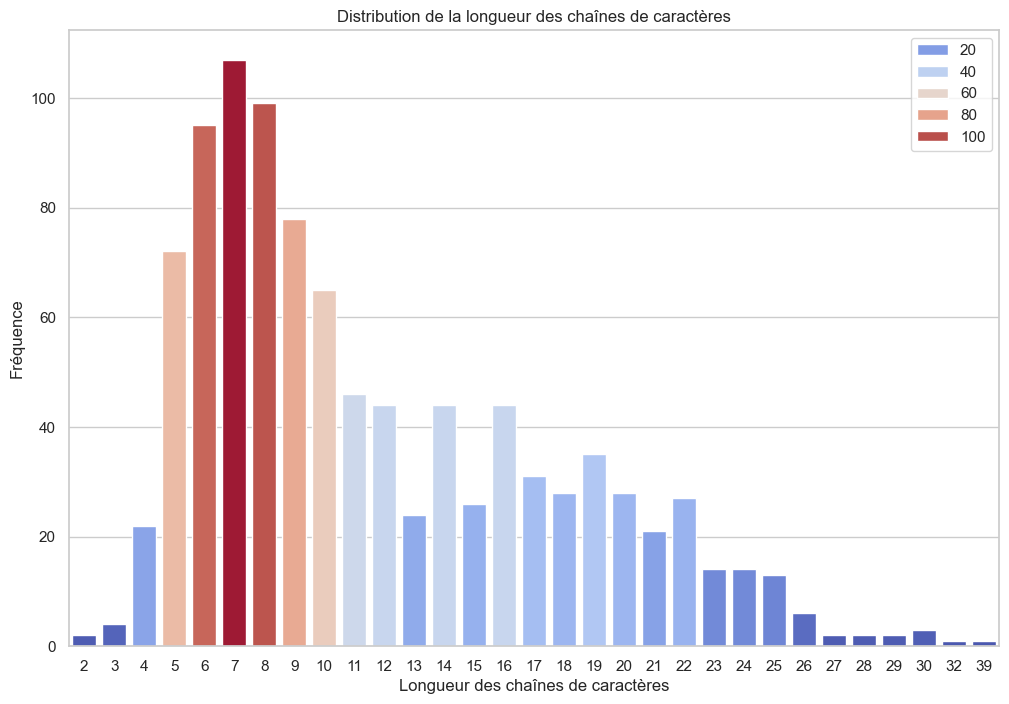

count    1000.000000
mean       11.742000
std         5.972362
min         2.000000
25%         7.000000
50%        10.000000
75%        16.000000
max        39.000000
Name: nom, dtype: float64

In [29]:
# Avec `freq_distribution()` : la distribution de la longueur des noms;
### EXERCICE : compléter ce bloc avec les bonnes instructions
# DEBUT DE BLOC
lengths = freq_distribution(df['nom'])
lengths.describe()
# FIN DE BLOC

In [30]:
# Avec `freq_char()` : la fréquences des caractères dans les noms;
### EXERCICE : compléter ce bloc avec les bonnes instructions
# DEBUT DE BLOC
freq_char(df['nom'])
# FIN DE BLOC

Nombre de caractères distincts : 38


,Caractère,Fréquence,Ratio Freq (%)
4,e,1253,10.671095
7,a,1006,8.567535
9,n,900,7.664793
6,s,883,7.520014
13,r,836,7.119741
5,l,826,7.034577
8,i,820,6.983478
10,-,771,6.566173
11,o,596,5.075796
12,u,589,5.016181


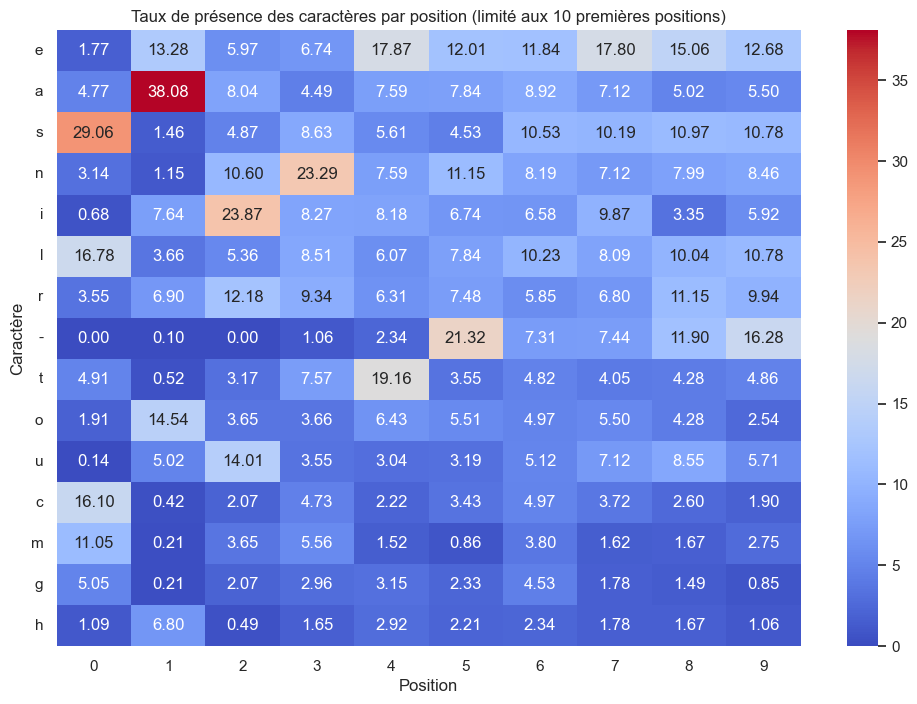

In [31]:
# Avec `rate_freq_by_position()` le taux de fréquence par rapport aux positions dans la chaîne de caractères;
### EXERCICE : compléter ce bloc avec les bonnes instructions
# DEBUT DE BLOC
rate_freq_by_position(df['nom'])
# FIN DE BLOC

In [32]:
# Avec `freq_composition_element()` la fréquence des composants de nom;
### EXERCICE : compléter ce bloc avec les bonnes instructions
# DEBUT DE BLOC
freq_composition_element(df['nom'])
# FIN DE BLOC

Nombre total de composants distincts : 1400
dont 15 exemples :


,Élément,Fréquence
661,goussogan,1
136,sanges,1
243,campeluiaco,1
1229,olies,1
1006,sentac,1
275,lapoury,1
1174,bonnet,1
464,maussion,1
1053,shiencort,1
833,aighe,1


Nombre total de composants présents plus d'une fois : 41
dont les 15 premiers :


,Élément,Fréquence
1,saint,143
4,sur,75
55,le,53
76,la,40
9,en,27
12,de,24
105,les,16
52,lès,15
377,et,8
626,d,8


Distribution de la fréquence du nombre de composants (en valeur) :


,count
nom,
1,548
2,176
3,171
4,87
5,16
6,2


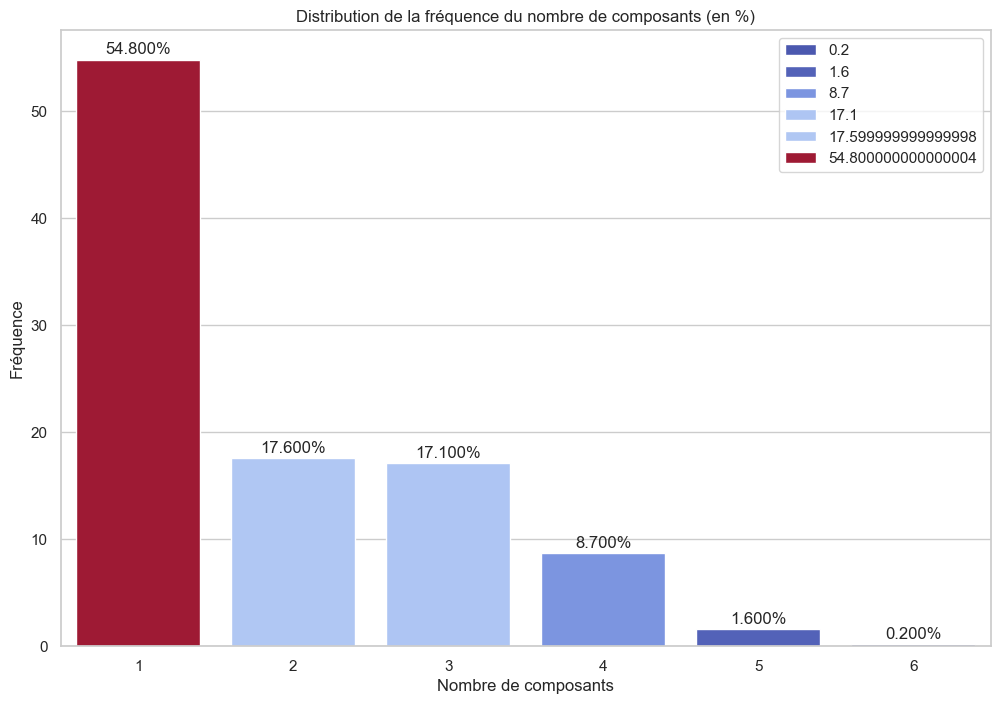

In [33]:
# Avec `composition_distribution()` le nombre de composant de noms de communes et leur distribution.
### EXERCICE : compléter ce bloc avec les bonnes instructions
# DEBUT DE BLOC
composition_distribution(df['nom'])
# FIN DE BLOC

Quelles réflexions peut-on avoir au sujet de ce qu'a appris, ou n'a pas appris, le modèle ?